#### Import required packages

In [219]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as pltmpma
from itertools import chain
import glob
import os
import matplotlib.colors
from utils import * 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TO DO:

- Take care of length mistmatch between slip vector and shmax for some events
- Check RHR applies to strike to not mess up slip vector calculation
- Calculate angle between shmax and slip vector
- Fit regression of fracture angle vs shmax and slip vector angle

### Load data

In [220]:
data_dir = 'FDHI_data/'

# Data from the FDHI database 
FDHI_data = pd.read_excel(str(data_dir +'data_FDHI.xlsx')) # FDHI data
california_rows = FDHI_data[FDHI_data['region'] == 'California']
unique_eq_names = california_rows['eq_name'].unique()

# Additional info (not in FDHI database, refs in excel file)
data_for_calc = pd.read_csv(str(data_dir +'extra_data.csv')) 

# Slip data from FDHI appendix
slip_data = pd.read_csv(str(data_dir +'02_FDHI_FLATFILE_MEASUREMENTS_20220719.csv')) 
CA_slip_data = slip_data[slip_data['region'] == 'California']

# Event information
event_data = pd.read_excel(str(data_dir + 'event_data.xlsx'))
CA_event_data = event_data[event_data['event'].isin(unique_eq_names)]

# Stress data from Hardebeck community model
stress_data = pd.read_csv("SCEC_data/Hardebeck_FM.csv", skiprows=47) 
depth_choice = 5 # subset stress at depth slice of choice - default 5 km
stress_data_depthslice = stress_data[stress_data['DEP'] == depth_choice]
CA_event_data['Zone_numeric'] = CA_event_data['zone'].str[:-1] # UTM zones for each event

# Define the directory where the shapefiles are located
shapefile_directory = str(data_dir + 'ECS_lines_CA/')
shapefile_paths = [os.path.join(shapefile_directory, file) for file in os.listdir(shapefile_directory) if file.endswith('.shp')]

/var/folders/kg/j5ms0y1x28l_gm2jtsf5j4pr0000gn/T/ipykernel_37526/146680612.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_event_data['Zone_numeric'] = CA_event_data['zone'].str[:-1] # UTM zones for each event


### Extract and visualize stress data

In [221]:
xstress = stress_data_depthslice['# LON']
ystress = stress_data_depthslice['LAT']
SHmax = stress_data_depthslice['SHmax']

plot_ON_OFF = 'off'
R_ratio = stress_data_depthslice['R']

if plot_ON_OFF == 'on':
    plt.figure(dpi=300)
    plt.scatter(xstress, ystress, c=SHmax, cmap='coolwarm', marker='o')
    plt.colorbar(label='SHmax orientation at 5 km depth')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # plot ECS lines for each event on top of stress map 
    shapefile_paths = glob.glob(os.path.join(shapefile_directory, '*.shp'))
    for shapefile_path in shapefile_paths:
        gdf = gpd.read_file(shapefile_path)
        gdf.plot(ax=plt.gca(), color='black')  # Specify the current axis using plt.gca()
        
    plt.show()

    plt.figure(dpi=300)
    plt.scatter(xstress, ystress, c=R_ratio, cmap='magma', marker='o')
    plt.colorbar(label='R ratio at 5 km depth')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # plot ECS lines for each event on top of stress map 
    shapefile_paths = glob.glob(os.path.join(shapefile_directory, '*.shp'))
    for shapefile_path in shapefile_paths:
        gdf = gpd.read_file(shapefile_path)
        gdf.plot(ax=plt.gca(), color='white')  # Specify the current axis using plt.gca()
        
    plt.show()

### Measure fault segment angle differences

In [222]:
# variables that can be modified
plot_ON_OFF = 'off' # set whether plot of segment orientations gets made
stress_ON_OFF = 'off' # set whether stress field will get plotted too (fast, but extra calculations)
step = 10 # for downsampling really dense ECS lines, n of points to skip, default 1 if not set
vmin = 0 # to define angle color-coding range if plot on
vmax = 6
mag = 2000 # for vector arrow size in visualization, default 2000 if not set

In [223]:
segment_angle_differences = []
for i, shapefile_path in enumerate(shapefile_paths):

    # Getting the name of the corresponding event from the shapefile name
    # given the following pattern 'eventname_ECS.shp'
    shapefilename_path = shapefile_path.rsplit('/', 1)
    shapefilename = str(shapefilename_path[1])
    split_parts = shapefilename.split('_ECS.shp')
    eventname = split_parts[0]

    matching_rows = CA_event_data[CA_event_data['event'] == eventname]
    if eventname in ['SanFernando', 'ChalfantValley', 'OwensValley', 'Kern','Napa']: # remove non strike-slip events and events without stress data 
        continue   
    
    target_utm_zone = matching_rows['Zone_numeric'].to_numpy()
    target_utm_zone = int(target_utm_zone[0])
    utm_crs = f"+proj=utm +zone={target_utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    slip_event = CA_slip_data[CA_slip_data['eq_name'] == eventname]

    # Extract the x and y coordinates from the shapefile in UTM format
    x_coords,y_coords = extract_coordinates_shapefile(shapefile_path, target_utm_zone,step)

    # Calculate the angle of each line segment for vertex pairs
    angles = measure_angle_between_segments(x_coords, y_coords)
    segment_angle_differences.append(angles)
    
    if plot_ON_OFF == 'on': 
        fig, ax = plt.subplots(dpi=300)
        if stress_ON_OFF == 'on':
            # apply coordinate transformation, crop stress to match dimensions of event, and plot vector field
            xstress_utm, ystress_utm = extract_coordinates_stress(utm_crs, ystress, xstress)
            cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax = crop_stress_to_event(x_coords, y_coords,xstress_utm, ystress_utm, SHmax)
            ustress,vstress = unit_vector_stress(cropped_SHmax,mag)
            plt.quiver(cropped_xstress_utm, cropped_ystress_utm, ustress,vstress, angles='xy', scale_units='xy', scale=1, color='black', label='SHmax Orientation')
        else: 
            continue
        plot_segments_color_angle(vmin,vmax,x_coords,y_coords,angles,eventname)
        utm_hypox, utm_hypoy = find_event_hypocenter(slip_event, utm_crs)
        plt.scatter(utm_hypox, utm_hypoy, c='black', marker='*', s=100)

### Measure fault strike and fracture angle (shmax - strike)

In [224]:
# variables that can be modified
plot_ON_OFF = 'off' # set whether plot of segment orientations gets made
step = 10 # for downsampling really dense ECS lines, n of points to skip, default 1 if not set
vmin=0
vmax=90
mid_val=35
mag = 2000 # for vector arrow size in visualization, default 2000 if not set

In [225]:
fracture_angles = []
fault_segment_strikes= []
epi_frac_angle_all = []
shmax_all_segments = []

for i, shapefile_path in enumerate(shapefile_paths):
    # get shapefile and event data
    shapefilename_path = shapefile_path.rsplit('/', 1)
    shapefilename = str(shapefilename_path[1])
    split_parts = shapefilename.split('_ECS.shp')
    eventname = split_parts[0]
    matching_rows = CA_event_data[CA_event_data['event'] == eventname]
    target_utm_zone = matching_rows['Zone_numeric'].to_numpy()
    target_utm_zone = int(target_utm_zone[0])
    utm_crs = f"+proj=utm +zone={target_utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    slip_event = CA_slip_data[CA_slip_data['eq_name'] == eventname]
    if eventname in ['SanFernando', 'ChalfantValley', 'OwensValley', 'Kern','Napa']: # remove non strike-slip events and events without stress data 
        continue 
    # Extract the x and y coordinates from the shapefile in UTM format
    x_coords,y_coords = extract_coordinates_shapefile(shapefile_path, target_utm_zone,step)

    # Calculate the strike of each fault segment
    angles = measure_fault_strike(x_coords, y_coords)
    fault_segment_strikes.append(angles)
    
    # Calculate angle between each segment pair strike and nearest stress vector
    xstress_utm, ystress_utm = extract_coordinates_stress(utm_crs, ystress, xstress)
    cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax = crop_stress_to_event(x_coords, y_coords,xstress_utm, ystress_utm, SHmax)
    diff_angle, SHmax_segment = measure_fracture_angle(x_coords, y_coords, angles, cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax)
    fracture_angles.append(diff_angle)
    shmax_all_segments.append(SHmax_segment)

    # Find fracture angle and nearest slip value to epicenter
    utm_hypox, utm_hypoy = find_event_hypocenter(slip_event, utm_crs)
    frac_angle_epi = match_frac_angle_to_epicenter(x_coords, y_coords, utm_hypox, utm_hypoy, fracture_angles)
    epi_frac_angle_all.append(frac_angle_epi)

    if plot_ON_OFF == 'on':
        plt.figure(dpi=300)  
        # apply coordinate transformation, crop stress to match dimensions of event, and plot vector field    
        ustress,vstress = unit_vector_stress(cropped_SHmax,mag)
        plt.quiver(cropped_xstress_utm, cropped_ystress_utm, ustress,vstress, angles='xy', scale_units='xy', scale=1, color='black', label='SHmax Orientation')
        plot_segments_color_fracture_angle(vmin,vmax,mid_val,x_coords,y_coords,diff_angle,eventname)
        utm_hypox, utm_hypoy = find_event_hypocenter(slip_event, utm_crs)
        plt.scatter(utm_hypox, utm_hypoy, c='black', marker='*', s=100)

### Visualize and analyze distribution of fracture angle, fracture strike, and segment angle differences

In [226]:
# flatten angle arrays
segment_angle_differences_flattened = list(chain.from_iterable(segment_angle_differences))
fracture_angles_flattened = list(chain.from_iterable(fracture_angles))
fault_segment_strikes_flattened = list(chain.from_iterable(fault_segment_strikes))
shmax_all_segments_flattened = list(chain.from_iterable(shmax_all_segments))

plot_ON_OFF = 'off' # set whether histograms get plotted

In [227]:
if plot_ON_OFF == 'on':
    plt.figure(figsize=(4,6),dpi=300)
    plot_angle_distribution(311,segment_angle_differences_flattened,10,'lightsalmon','Segment strike difference (deg)')
    plot_angle_distribution(312,fault_segment_strikes_flattened,10,'goldenrod','Fault segment strike')
    plot_angle_distribution(313,fracture_angles_flattened,10,'darkkhaki',r'Fracture angle $\phi_s$ (deg)')
    plt.tight_layout()
    plt.show()

### Associate slip measurements to fault segments


In [228]:
# variables that can be modified
plot_ON_OFF = 'off' # set whether plot of segment orientations gets made
vmin=0
vmax=5
mid_val=30
num_closest = 1 # for n of displacement measurements considered per segment

In [229]:
rake_ref = {   
    'Right-Lateral': 180,
    'Left-Lateral': 0,
    'Normal': -90,
    'Reverse': 90
}

In [230]:
fault_max_slip = []
strain_drop_all = []
rupture_width_all_events = []
rupture_length_all_events = []
fault_normalized_slip = []
rake_all_events = []
epi_slip_all = []
slip_slip_all_normalized = []
event_name_all = []
slip_vector_all_segments= []
slip_vector_angle_all_segments = []

for i, shapefile_path in enumerate(shapefile_paths):
    # get shapefile and event data
    shapefilename_path = shapefile_path.rsplit('/', 1)
    shapefilename = str(shapefilename_path[1])
    split_parts = shapefilename.split('_ECS.shp')
    eventname = split_parts[0]
    matching_rows = CA_event_data[CA_event_data['event'] == eventname]
    target_utm_zone = matching_rows['Zone_numeric'].to_numpy()
    target_utm_zone = int(target_utm_zone[0])
    utm_crs = f"+proj=utm +zone={target_utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
    slip_event = CA_slip_data[CA_slip_data['eq_name'] == eventname]
    
    # get width and length of rupture for later calculations
    row_with_event = data_for_calc[data_for_calc['Event'] == eventname]
    rupture_width = row_with_event['Width (km)']
    rupture_length = row_with_event['Rupture length (m)']
    if eventname in ['SanFernando', 'ChalfantValley', 'OwensValley', 'Kern','Napa']: # remove non strike-slip events and events without stress data 
        continue 
    # Extract the x and y coordinates from the shapefile in UTM format
    x_coords,y_coords = extract_coordinates_shapefile(shapefile_path, target_utm_zone,step)
    # Prep slip data for each event by removing -999 and 0s (allowing geodetic + field slip)
    slipx, slipy, slip_preferred, rake = prepare_slip_data(slip_event,utm_crs)
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    
    # find slip and rake for each segment
    rake = rake.map(rake_ref)
    rake = rake.values.flatten()
    max_slip_preferred, rake_segment = match_slip_to_segment(x_coords, y_coords, slipx, slipy, slip_preferred, rake, num_closest)
    max_to_normalize = np.max(max_slip_preferred)
    fault_max_slip.append(max_slip_preferred)
    fault_normalized_slip.append(max_slip_preferred/max_to_normalize)
    event_name_all.append(np.array(np.repeat(eventname,len(max_slip_preferred))))
    rake_all_events.append(rake_segment)
    
    # get stress field for event
    xstress_utm, ystress_utm = extract_coordinates_stress(utm_crs, ystress, xstress)
    cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax = crop_stress_to_event(x_coords, y_coords, xstress_utm, ystress_utm, SHmax)
    
    # calculate slip vector from fault strike and rake and measure angle between shmax and slip vector, assumes slip vector on plane
    strike = measure_fault_strike(x_coords, y_coords) # already calculated before, may optimize later?
    diff_angle, SHmax_segment = measure_fracture_angle(x_coords, y_coords, strike, cropped_xstress_utm, cropped_ystress_utm, cropped_SHmax) # already calculated before, may optimize later?
    slip_vector_segment = convert_rake_to_slip_vector(rake_segment,strike)
    slip_vector_all_segments.append(slip_vector_segment)
    angle_shmax_slip_vector = measure_slip_vector_angle(slip_vector_segment,SHmax_segment)
    slip_vector_angle_all_segments.append(angle_shmax_slip_vector)

    # Calculate strain drop (for later)
    strain_drop = calculate_strain_drop(x_coords,y_coords,max_slip_preferred)
    strain_drop_all.append(strain_drop)
    rupture_width_all_events.append(np.array(np.repeat(rupture_width,len(strain_drop))))
    rupture_length_all_events.append(np.array(np.repeat(rupture_length,len(strain_drop))))

    # Find nearest slip value to epicenter
    utm_hypox, utm_hypoy = find_event_hypocenter(slip_event, utm_crs)
    slip_epi = match_slip_to_epicenter(x_coords, y_coords, utm_hypox, utm_hypoy, slip_preferred)
    epi_slip_all.append(slip_epi)
    slip_slip_all_normalized.append(slip_epi/max_to_normalize)

    if plot_ON_OFF == 'on':
        plt.figure(dpi=300)  
        # apply coordinate transformation, crop stress to match dimensions of event, and plot vector field    
        ustress,vstress = unit_vector_stress(cropped_SHmax,mag)
        plt.quiver(cropped_xstress_utm, cropped_ystress_utm, ustress,vstress, angles='xy', scale_units='xy', scale=1, color='black', label='SHmax Orientation')
        log_slip_preferred = np.log10(slip_preferred)  # Taking logarithm of the color values
        plt.scatter(slipx, slipy, s=20, c=log_slip_preferred,cmap='magma',alpha=0.4,edgecolors='none')
        plot_segments_slip_color(x_coords,y_coords,max_slip_preferred,eventname,vmin,vmax)
        plt.scatter(utm_hypox, utm_hypoy, c='black', marker='*', s=100)

#### Analysis of angles between slip vector angle and fracture angle

Text(0, 0.5, 'Slip vector angle')

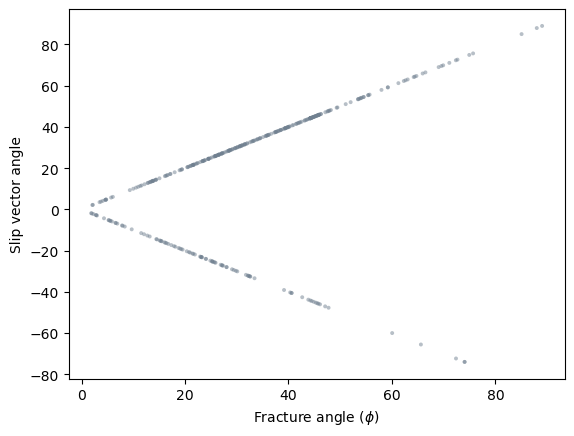

In [246]:
slip_vector_angle_all_segments_flattened = list(chain.from_iterable(slip_vector_angle_all_segments))
plt.figure()
plt.scatter(fracture_angles_flattened,slip_vector_angle_all_segments_flattened,s=8,alpha=0.5,edgecolor='None',c='slategrey')
plt.xlabel(r'Fracture angle ($\phi$)')
plt.ylabel('Slip vector angle')

#### Additional visualization - slip and fracture angle

In [232]:
plot_ON_OFF = 'off'
fault_max_slip_flattened = list(chain.from_iterable(fault_max_slip))
fault_normalized_slip_flattened = list(chain.from_iterable(fault_normalized_slip))

if plot_ON_OFF == 'on':
    plt.figure(dpi=300)
    plt.hist2d(fracture_angles_flattened, fault_max_slip_flattened, bins=8, cmap='Oranges',norm=matplotlib.colors.LogNorm())
    plt.colorbar(label='Density')
    plt.xlabel(r'$\alpha_{f}$ (degrees)')
    plt.ylabel('Slip magnitude (m)')
    plt.show()

if plot_ON_OFF == 'on':
    plt.figure(dpi=300)
    plt.hist2d(fracture_angles_flattened, fault_normalized_slip_flattened, bins=8, cmap='Oranges',norm=matplotlib.colors.LogNorm())
    plt.colorbar(label='Density')
    plt.xlabel(r'$\alpha_{f}$ (degrees)')
    plt.ylabel('Normalized slip magnitude')
    plt.show()

### Collect measurements into single dataframe

In [233]:
event_slip_angle_data = pd.DataFrame()
event_name_all_flattened = list(chain.from_iterable(event_name_all))
event_slip_angle_data['Event'] = event_name_all_flattened
event_slip_angle_data['Fracture angle'] = fracture_angles_flattened
event_slip_angle_data['Slip'] = fault_max_slip_flattened
event_slip_angle_data['Normalized slip'] = fault_normalized_slip_flattened


### Investigating trade offs between fracture angle and fault curvature

In [234]:
# plt.figure()
# plt.plot(fracture_angles_flattened,segment_angle_differences_flattened,'o',color='darkkhaki',markersize=2)
# plt.ylabel('Segment angle difference (deg)')
# plt.xlabel('Fracture angle (deg)')

### Investigating trade offs between epicentral location, fracture angle, and slip

In [235]:
plot_ON_OFF = 'off'
if plot_ON_OFF == 'on':
    plt.figure(dpi=300)
    plt.hist(epi_frac_angle_all,bins=5)
    plt.xlabel(r'$\alpha_{f}$ (degrees)')
    plt.ylabel('Frequency')
    plt.show()

if plot_ON_OFF == 'on':
    plt.figure(dpi=300)
    plt.hist(slip_slip_all_normalized,bins=5)
    plt.xlabel('Slip (m)')
    plt.ylabel('Frequency')
    plt.show()

### Extract additional info for friction models

In [236]:
flattened_rupture_width_all_events = [element for sublist in rupture_width_all_events for element in sublist]
flattened_rupture_length_all_events = [element for sublist in rupture_length_all_events for element in sublist]

In [237]:
postseismic_rotation = 10 # let's go MC on this later
W = flattened_rupture_width_all_events*1000 # m
W = [element * 1000 for element in W]
G = 30*10**10 # 30 GPa
L = flattened_rupture_length_all_events # m

### Estimate parameters for friction model

In [238]:
differential_stress = 20*10**6 # Pa
plot_ON_OFF = 'off'
shear_stress = []
for fracture_angle in fracture_angles_flattened:
    shear_stress.append(calculate_shear_stress(differential_stress,fracture_angle))

normal_stress_plus_center = []
for fracture_angle,shear_stressi in zip(fracture_angles_flattened,shear_stress):
    normal_stress_plus_center.append(calculate_normal_stress(differential_stress,fracture_angle,shear_stressi))

In [239]:
# Divide all elements in the lists by 10^3 (1000)
power = 0
divisor = 10 ** power

normal_stress_divided = [stress / divisor for stress in normal_stress_plus_center]
shear_stress_divided = [stress / divisor for stress in shear_stress]

event_slip_angle_data['Shear stress'] = shear_stress_divided
event_slip_angle_data['Normal stress'] = normal_stress_divided

In [240]:
if plot_ON_OFF == 'on':
    plt.figure(dpi=300)
    plt.scatter(normal_stress_divided,shear_stress_divided,s=15,c=fault_normalized_slip_flattened,cmap='Oranges',alpha=0.5,edgecolors='none')#,norm=matplotlib.colors.LogNorm())
    plt.colorbar(label='Normalized slip')
    plt.xlabel('Center - Normal stress (MPa)')
    plt.ylabel('Shear stress (MPa)')
    plt.axis('equal')

    # Iterate over unique events and plot
    for event in event_slip_angle_data['Event'].unique():
        plt.figure(dpi=300)
        event_data = event_slip_angle_data[event_slip_angle_data['Event'] == event]
        plt.scatter(event_data['Normal stress'], event_data['Shear stress'], c=event_data['Normalized slip'],cmap='Oranges',alpha=0.5,edgecolors='none')#,norm=matplotlib.colors.LogNorm())
        plt.axvline(x=0,c='k')
        plt.xlim(0,max(event_data['Shear stress']))
        #plot_instability(event_data['Normal stress'])
        plt.title(event)
        plt.colorbar(label='Normalized slip')
        plt.xlabel('Center - Normal stress (MPa)')
        plt.ylabel('Shear stress (MPa)')
        plt.axis('equal')